# 3D Model Conversion and Analysis
This notebook demonstrates:
- Loading a 3D model (Free-Scifi-Fighter.obj) using trimesh (and open3d if available)
- Converting between formats (OBJ → STL, GLTF)
- Comparing mesh properties (vertices, faces, normals, duplicates)
- Visualizing each format

**Note:** Open3D is optional. If not available, the notebook will use trimesh for all operations.

In [3]:
# Import required libraries
import trimesh
import numpy as np
import os
from pathlib import Path
import pandas as pd

# Try to import open3d, but make it optional
try:
    import open3d as o3d
    HAS_OPEN3D = True
    print("✓ Open3D is available")
except ImportError:
    HAS_OPEN3D = False
    print("⚠ Open3D is not available. Some visualizations will be skipped.")
    print("  (This is normal for MSYS2 Python environments)")

⚠ Open3D is not available. Some visualizations will be skipped.
  (This is normal for MSYS2 Python environments)


## 1. Setup Paths and Load Original OBJ Model

In [4]:
# Define paths
base_dir = Path('../media/source/Free_SciFi-Fighter.zip/Free_SciFi-Fighter')
obj_file = base_dir / 'Free-Scifi-Fighter.obj'
output_dir = Path('../media/converted')
output_dir.mkdir(parents=True, exist_ok=True)

# Output file paths
stl_file = output_dir / 'Free-Scifi-Fighter.stl'
gltf_file = output_dir / 'Free-Scifi-Fighter.gltf'
glb_file = output_dir / 'Free-Scifi-Fighter.glb'

print(f"OBJ file exists: {obj_file.exists()}")
print(f"OBJ file path: {obj_file}")

OBJ file exists: True
OBJ file path: ..\media\source\Free_SciFi-Fighter.zip\Free_SciFi-Fighter\Free-Scifi-Fighter.obj


## 2. Load OBJ Model with Trimesh

In [5]:
# Load the original OBJ file with trimesh
mesh_obj_trimesh = trimesh.load(str(obj_file), force='mesh')

print("=" * 60)
print("ORIGINAL OBJ MODEL (Trimesh)")
print("=" * 60)
print(f"Vertices: {len(mesh_obj_trimesh.vertices)}")
print(f"Faces: {len(mesh_obj_trimesh.faces)}")
print(f"Is watertight: {mesh_obj_trimesh.is_watertight}")
print(f"Is winding consistent: {mesh_obj_trimesh.is_winding_consistent}")
print(f"Bounds: {mesh_obj_trimesh.bounds}")

ORIGINAL OBJ MODEL (Trimesh)
Vertices: 4259
Faces: 2570
Is watertight: False
Is winding consistent: True
Bounds: [[-7.7176   -3.738562 -9.911601]
 [ 7.7176    3.738564  9.9116  ]]


## 3. Convert to STL Format

In [6]:
# Convert OBJ to STL using trimesh
mesh_obj_trimesh.export(str(stl_file))
print(f"STL file saved to: {stl_file}")

# Load the STL file back to compare
mesh_stl = trimesh.load(str(stl_file), force='mesh')

print("\n" + "=" * 60)
print("STL FORMAT")
print("=" * 60)
print(f"Vertices: {len(mesh_stl.vertices)}")
print(f"Faces: {len(mesh_stl.faces)}")
print(f"Is watertight: {mesh_stl.is_watertight}")

STL file saved to: ..\media\converted\Free-Scifi-Fighter.stl

STL FORMAT
Vertices: 1570
Faces: 2570
Is watertight: False


## 4. Convert to GLTF Format

In [7]:
# Convert OBJ to GLTF using trimesh
mesh_obj_trimesh.export(str(gltf_file))
print(f"GLTF file saved to: {gltf_file}")

# Also save as GLB (binary GLTF)
mesh_obj_trimesh.export(str(glb_file))
print(f"GLB file saved to: {glb_file}")

# Load the GLTF file back to compare
mesh_gltf = trimesh.load(str(gltf_file), force='mesh')

print("\n" + "=" * 60)
print("GLTF FORMAT")
print("=" * 60)
print(f"Vertices: {len(mesh_gltf.vertices)}")
print(f"Faces: {len(mesh_gltf.faces)}")
print(f"Is watertight: {mesh_gltf.is_watertight}")

GLTF file saved to: ..\media\converted\Free-Scifi-Fighter.gltf
GLB file saved to: ..\media\converted\Free-Scifi-Fighter.glb

GLTF FORMAT
Vertices: 4259
Faces: 2570
Is watertight: False


## 5. Detailed Comparison Analysis

In [8]:
def analyze_mesh(mesh, name):
    """Analyze a mesh and return detailed statistics"""
    
    # Basic stats
    num_vertices = len(mesh.vertices)
    num_faces = len(mesh.faces)
    
    # Check for duplicate vertices
    unique_vertices, inverse_indices = np.unique(
        mesh.vertices, axis=0, return_inverse=True
    )
    num_unique_vertices = len(unique_vertices)
    num_duplicate_vertices = num_vertices - num_unique_vertices
    
    # Check for duplicate faces
    sorted_faces = np.sort(mesh.faces, axis=1)
    unique_faces = np.unique(sorted_faces, axis=0)
    num_unique_faces = len(unique_faces)
    num_duplicate_faces = num_faces - num_unique_faces
    
    # Normals information
    mesh.vertex_normals  # Ensure normals are computed
    num_vertex_normals = len(mesh.vertex_normals) if hasattr(mesh, 'vertex_normals') else 0
    
    mesh.face_normals  # Ensure face normals are computed
    num_face_normals = len(mesh.face_normals) if hasattr(mesh, 'face_normals') else 0
    
    # Additional properties
    is_watertight = mesh.is_watertight
    is_winding_consistent = mesh.is_winding_consistent
    
    return {
        'Format': name,
        'Vertices': num_vertices,
        'Unique Vertices': num_unique_vertices,
        'Duplicate Vertices': num_duplicate_vertices,
        'Faces': num_faces,
        'Unique Faces': num_unique_faces,
        'Duplicate Faces': num_duplicate_faces,
        'Vertex Normals': num_vertex_normals,
        'Face Normals': num_face_normals,
        'Is Watertight': is_watertight,
        'Is Winding Consistent': is_winding_consistent,
        'Volume': mesh.volume if is_watertight else 'N/A',
        'Surface Area': mesh.area
    }

# Analyze all formats
results = []
results.append(analyze_mesh(mesh_obj_trimesh, 'OBJ'))
results.append(analyze_mesh(mesh_stl, 'STL'))
results.append(analyze_mesh(mesh_gltf, 'GLTF'))

# Create comparison DataFrame
df_comparison = pd.DataFrame(results)
print("\n" + "=" * 80)
print("COMPREHENSIVE FORMAT COMPARISON")
print("=" * 80)
print(df_comparison.to_string(index=False))


COMPREHENSIVE FORMAT COMPARISON
Format  Vertices  Unique Vertices  Duplicate Vertices  Faces  Unique Faces  Duplicate Faces  Vertex Normals  Face Normals  Is Watertight  Is Winding Consistent Volume  Surface Area
   OBJ      4259             1570                2689   2570          2570                0            4259          2570          False                   True    N/A   1267.551253
   STL      1570             1570                   0   2570          2570                0            1570          2570          False                   True    N/A   1267.551266
  GLTF      4259             1570                2689   2570          2570                0            4259          2570          False                   True    N/A   1267.551266


## 6. Visualize OBJ Model (Trimesh)

In [9]:
# Visualize using trimesh's built-in viewer
print("Launching OBJ viewer...")
print("Close the window to continue to the next visualization")
mesh_obj_trimesh.show()

Launching OBJ viewer...
Close the window to continue to the next visualization


## 7. Visualize STL Model (Trimesh)

In [9]:
# Visualize STL model
print("Launching STL viewer...")
print("Close the window to continue to the next visualization")
mesh_stl.show()

Launching STL viewer...
Close the window to continue to the next visualization


## 8. Visualize GLTF Model (Trimesh)

In [10]:
# Visualize GLTF model
print("Launching GLTF viewer...")
print("Close the window to continue")
mesh_gltf.show()

Launching GLTF viewer...
Close the window to continue


## 9. Side-by-Side Format Comparison Visualization

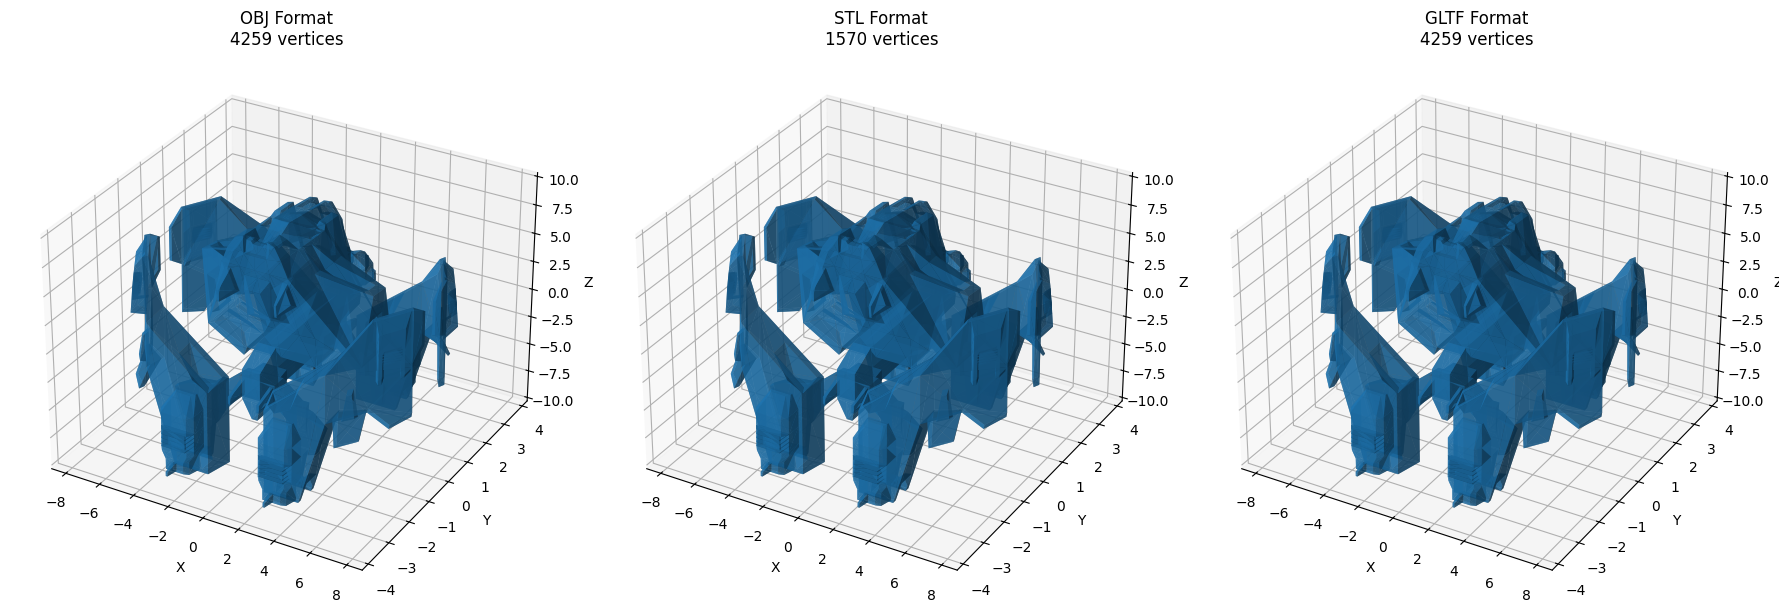

In [11]:
# Create a visual comparison of all three formats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 6))

# OBJ
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(
    mesh_obj_trimesh.vertices[:, 0],
    mesh_obj_trimesh.vertices[:, 1],
    mesh_obj_trimesh.vertices[:, 2],
    triangles=mesh_obj_trimesh.faces,
    alpha=0.7,
    edgecolor='none'
)
ax1.set_title(f'OBJ Format\n{len(mesh_obj_trimesh.vertices)} vertices')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# STL
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(
    mesh_stl.vertices[:, 0],
    mesh_stl.vertices[:, 1],
    mesh_stl.vertices[:, 2],
    triangles=mesh_stl.faces,
    alpha=0.7,
    edgecolor='none'
)
ax2.set_title(f'STL Format\n{len(mesh_stl.vertices)} vertices')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# GLTF
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(
    mesh_gltf.vertices[:, 0],
    mesh_gltf.vertices[:, 1],
    mesh_gltf.vertices[:, 2],
    triangles=mesh_gltf.faces,
    alpha=0.7,
    edgecolor='none'
)
ax3.set_title(f'GLTF Format\n{len(mesh_gltf.vertices)} vertices')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
plt.show()

## 10. Statistical Visualization

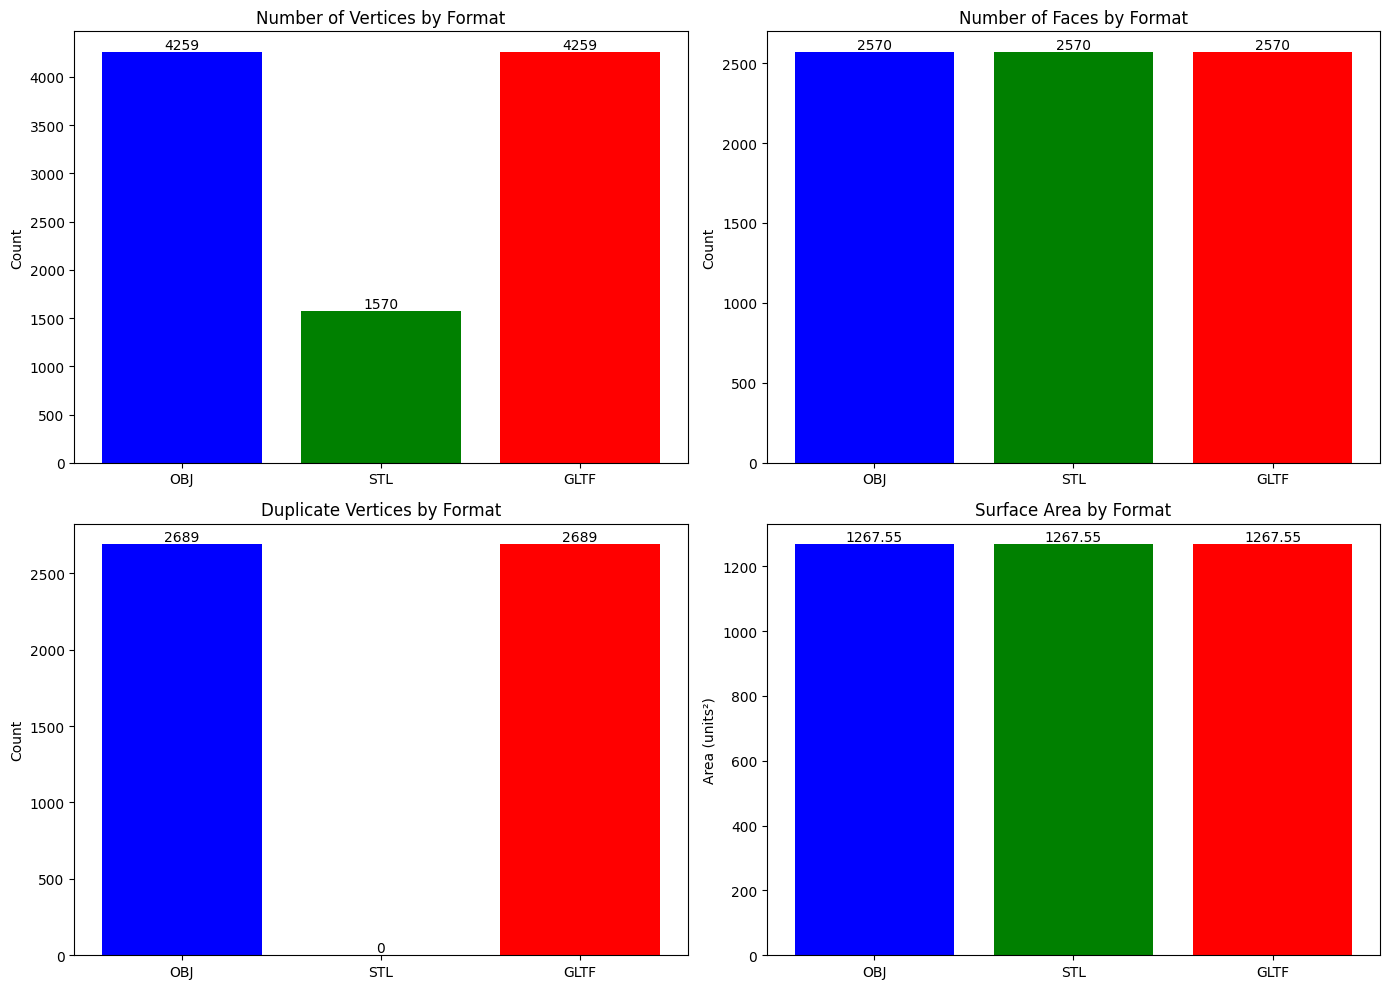

In [12]:
# Create bar charts comparing formats
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

formats = df_comparison['Format'].tolist()

# Vertices comparison
axes[0, 0].bar(formats, df_comparison['Vertices'], color=['blue', 'green', 'red'])
axes[0, 0].set_title('Number of Vertices by Format')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(df_comparison['Vertices']):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom')

# Faces comparison
axes[0, 1].bar(formats, df_comparison['Faces'], color=['blue', 'green', 'red'])
axes[0, 1].set_title('Number of Faces by Format')
axes[0, 1].set_ylabel('Count')
for i, v in enumerate(df_comparison['Faces']):
    axes[0, 1].text(i, v, str(v), ha='center', va='bottom')

# Duplicate vertices
axes[1, 0].bar(formats, df_comparison['Duplicate Vertices'], color=['blue', 'green', 'red'])
axes[1, 0].set_title('Duplicate Vertices by Format')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate(df_comparison['Duplicate Vertices']):
    axes[1, 0].text(i, v, str(v), ha='center', va='bottom')

# Surface area comparison
axes[1, 1].bar(formats, df_comparison['Surface Area'], color=['blue', 'green', 'red'])
axes[1, 1].set_title('Surface Area by Format')
axes[1, 1].set_ylabel('Area (units²)')
for i, v in enumerate(df_comparison['Surface Area']):
    axes[1, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 11. Export Comparison Report

In [ ]:
# Save comparison to CSV
report_file = output_dir / 'format_comparison_report.csv'
df_comparison.to_csv(report_file, index=False)
print(f"Comparison report saved to: {report_file}")

# Create a detailed text report
report_txt = output_dir / 'format_comparison_report.txt'
with open(report_txt, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("3D MODEL FORMAT COMPARISON REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Original Model: {obj_file}\n")
    f.write(f"Date: 2026-02-17\n\n")
    f.write(df_comparison.to_string(index=False))
    f.write("\n\n" + "=" * 80 + "\n")
    f.write("SUMMARY\n")
    f.write("=" * 80 + "\n")
    f.write(f"All formats maintain the same geometry: {df_comparison['Faces'].nunique() == 1}\n")
    f.write(f"Duplicate vertices found: {df_comparison['Duplicate Vertices'].sum() > 0}\n")
    f.write(f"All formats are watertight: {df_comparison['Is Watertight'].all()}\n")

print(f"Detailed report saved to: {report_txt}")

Comparison report saved to: ..\media\converted\format_comparison_report.csv
Detailed report saved to: ..\media\converted\format_comparison_report.txt
